# Visualizing Model Output
#### Overview
In this notebook, we will look at a few ways to visualize ocean model output. As in previous lessons, we will use output from the ECCO Ocean State Estimate (Version 4).

#### Import Modules
First, import the modules required to access data from netCDF files and create plots:

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature


## Working with data
In ocean modeling, we need to work with lots of data - so much that we often cannot store all of this data on our laptops. In this notebook, we will start to work with data files stored in a different location than our notebook.

To begin, define a path below where you will store your data. Ideally, this location is on a flash drive or external drive with additional storage, separate from your central drive on your machine.

In [3]:
# Define a path to a data folder
data_folder = '/Users/johnathonlu/Documents/SJSU/cs185c_spring2025/Data'

With a look to the next step, we will be working with data from a model generated by NASA's ECCO consortium. Run the next cell to make a folder called `ECCO` and update your path to include this folder:

In [4]:
# make a new folder called ECCO in the data folder if it doesn't exists
if 'ECCO' not in os.listdir(data_folder):
    os.mkdir(os.path.join(data_folder,'ECCO'))

## Downloading Data Automatically 
Since we'll be using lots of data, it's helpful to design code that will allow us to download data automatically rather than clicking on links for individual files. One example of such code for the ECCO data is available on the course notes Github [HERE](https://github.com/ProfMikeWood/ocean_modeling_book/blob/main/tools/Downloading%20ECCO%20Data.ipynb). Download this notebook and store it in your Lecture 3-1 folder.

You will also need your WedDAV credentials, available [HERE](https://ecco.jpl.nasa.gov/drive/). Note that this is a different set of credentials that you use to sign into the file server.

Once the notebook is downloaded, edit the cell blocks to download the files that meet the following specifications:

``` version = 'Version4'
release = 'Release4'
subset = 'interp_monthly'
var_name = 'THETA'
start_year = 2015
end_year = 2015
```

## Plotting profiles
With the data in hand, we are now ready to begin visualizing model differences across space and time. As a first start, let's begin by investigating vertical profiles of temperature in the Labrador Sea - an important location for thermohaline circulation in the Arctic.

The Labrador sea is located off the east coast of Canada where sea ice forms seasonally. This creates large swings in temperature at the surface of the ocean. Let's investigate profiles of temperature in the Labrador sea between the sea ice maximum in **March** and the sea ice minimum in **September**.

In [5]:
# identify path to the march data file
march_file = os.path.join(data_folder,'ECCO','Version4','Release4',
                          'interp_monthly','THETA','THETA_2015_03.nc')

# identify path to the sept data file
sept_file = os.path.join(data_folder,'ECCO','Version4','Release4',
                          'interp_monthly','THETA','THETA_2015_09.nc')

In [6]:
# read in the march THETA data along with the lon, lat, and depth information
ds = xr.open_dataset(march_file)
longitude = np.array(ds['longitude'][:])
latitude = np.array(ds['latitude'][:])
#depth
Z = np.array(ds['Z'][:])
Theta_march = np.array(ds['THETA'][:])
ds.close()

# read in the september THETA data
ds = xr.open_dataset(sept_file)
# Don't need to read coordinates again.
Theta_sept = np.array(ds['THETA'][:])
ds.close

<bound method DataWithCoords.close of <xarray.Dataset> Size: 104MB
Dimensions:    (i: 720, k: 50, j: 360, time: 1, nv: 2)
Coordinates:
  * i          (i) int64 6kB 0 1 2 3 4 5 6 7 ... 712 713 714 715 716 717 718 719
  * k          (k) int64 400B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * j          (j) int64 3kB 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
  * time       (time) datetime64[ns] 8B 2015-09-16
    latitude   (j) float64 3kB ...
    longitude  (i) float64 6kB ...
    Z          (k) float32 200B ...
    timestep   (time) int64 8B ...
    time_bnds  (time, nv) datetime64[ns] 16B ...
Dimensions without coordinates: nv
Data variables:
    THETA      (time, k, j, i) float64 104MB ...
Attributes: (12/20)
    product_time_coverage_start:  1992-01-01T12:00:00
    author:                       Ou Wang and Ian Fenty
    Insitution:                   JPL
    product_version:              ECCO Version 4 Release 4
    time_units:                   days since 1992-01-0

Now that we've got our data read in, we need to find the location in the data matrix where the Labrador sea is located. The center of the Labrador Sea is around -50$^{\circ}$E, 57.4$^{\circ}$N. One way we can find the indices corresponding to these locations is as follows:

In [7]:
# find the lon index closest to -50 E
lon_index = np.argmin(np.abs(longitude - (-50)))

# find the lat index closest to 57.4 N
lat_index = np.argmin(np.abs(latitude - (57.4)))

# sanity check
print('The longitude at index',lon_index,'is',longitude[lon_index])
print('The latitude at index',lat_index,'is',latitude[lat_index])


The longitude at index 259 is -50.25
The latitude at index 294 is 57.25


We can visualize the location of this point as follows:

/opt/anaconda3/envs/cs185c/lib/python3.11/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


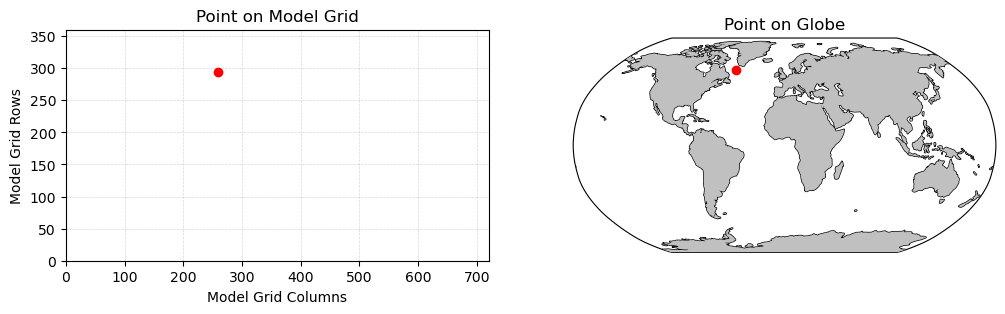

In [52]:
fig = plt.figure(figsize=(12,3))

plt.subplot(1,2,1)
plt.plot(lon_index, lat_index, 'ro')
plt.gca().set_xlim([0,len(longitude)])
plt.gca().set_ylim([0,len(latitude)])
plt.xlabel('Model Grid Columns')
plt.ylabel('Model Grid Rows')
plt.grid(linestyle='--',linewidth=0.5,alpha=0.5)
plt.title('Point on Model Grid')

plt.subplot(1,2,2,projection=ccrs.Robinson())
# ax = plt.axes()
C = plt.plot(longitude[lon_index], latitude[lat_index], 'ro',
                   transform=ccrs.PlateCarree())
plt.gca().add_feature(cfeature.LAND, zorder=99, facecolor='silver')
plt.gca().coastlines()
plt.gca().set_global()
plt.title('Point on Globe')
plt.show()

Next, we can use these indices to sample our data:

In [9]:
# sample march data on the longitude and latitude indices
# 0 is something, : is all depth
theta_march = Theta_march[0, :, lat_index, lon_index]

# sample sept data on the longitude and latitude indices
theta_sept = Theta_sept[0, :, lat_index, lon_index]


Finally, we can make a plot of these profiles as follows:

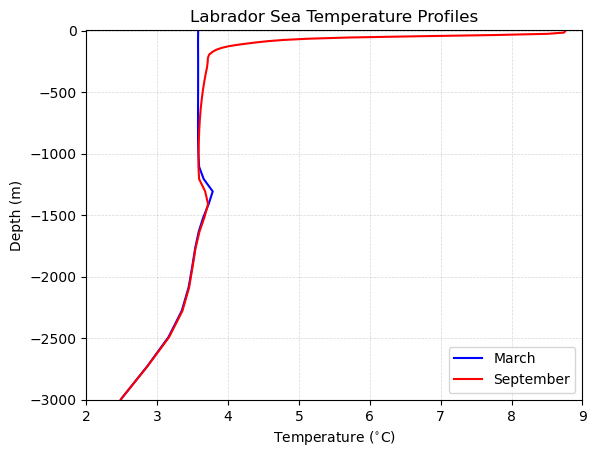

In [10]:
# make a figure
fig = plt.figure()

# plot the march profile in blue
plt.plot(theta_march, Z, '-', color='blue', label='March')

# plot the sept profile in red
plt.plot(theta_sept, Z, '-', color='red', label='September')


# add a legend in the 4th quadrant
plt.legend(loc = 4)

# format the axes
plt.gca().set_xlim([2,9])
plt.gca().set_ylim([-3000,5])
plt.ylabel('Depth (m)')
plt.xlabel('Temperature ($^{\circ}$C)')
plt.title('Labrador Sea Temperature Profiles')
plt.grid(linestyle='--',linewidth=0.5,alpha=0.5)

# show the plot
plt.show()

## &#x1F914; Try it for yourself
In the plot above, we can see how the temperature varies between the end of winter and the end of summer in the Labrador Sea. How about the other main property of sea water - salinity? In the cells below, work through the following steps to make an equivalent plot for salinity

#### Step 1: Download the 2015 salinity data
Using the downloading notebook presented above, download the salinity data by changing the `var_name` to `SALT` and re-running the cells.

#### Step 2: Read in the salinity profiles
Using the indices for Labrador Sea we identified above, read in the salinity profiles in March and September:

In [36]:

# identify path to the march data file
march_file = os.path.join(data_folder,'ECCO','Version4','Release4',
                          'interp_monthly','SALT','SALT_2015_03.nc')

# identify path to the sept data file
sept_file = os.path.join(data_folder,'ECCO','Version4','Release4',
                          'interp_monthly','SALT','SALT_2015_09.nc')



In [37]:
# read in the march SALT data 
ds = xr.open_dataset(march_file)
longitude = np.array(ds['longitude'][:])
latitude = np.array(ds['latitude'][:])

Z = np.array(ds['Z'][:])
Salt_march = np.array(ds['SALT'][:])
ds.close()


# read in the sept SALT data
ds = xr.open_dataset(sept_file)
Salt_sept = np.array(ds['SALT'][:])
ds.close()


In [38]:
# find the lon index closest to -50 E
lon_index = np.argmin(np.abs(longitude - (-50)))

# find the lat index closest to 57.4 N
lat_index = np.argmin(np.abs(latitude - (57.4)))

# sanity check
print('The longitude at index',lon_index,'is',longitude[lon_index])
print('The latitude at index',lat_index,'is',latitude[lat_index])

# sample march data at the longitude and latitude indices
salt_march = Salt_march[0, :, lat_index, lon_index]

# sample sept data at the longitude and latitude indices
salt_sept = Salt_sept[0, :, lat_index, lon_index]

The longitude at index 259 is -50.25
The latitude at index 294 is 57.25


#### Step 3: Make a plot of the salinity profiles

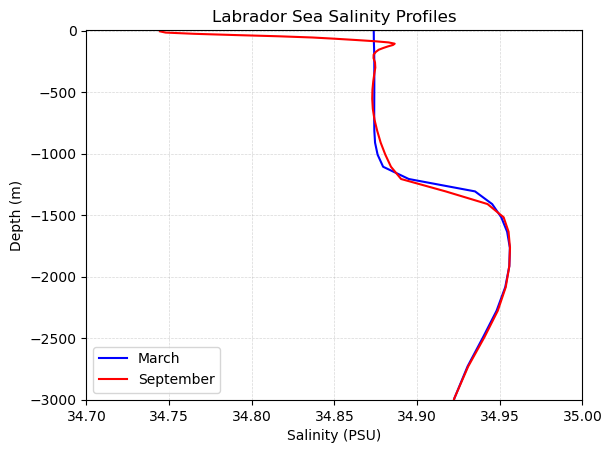

In [39]:
# make a figure
fig = plt.figure()

# plot the march profile in blue
plt.plot(salt_march, Z, '-', color='blue', label='March')

# plot the sept profile in red
plt.plot(salt_sept, Z, '-', color='red', label='September')


# add a legend in the 3rd quadrant
plt.legend(loc = 3)

# format the axes
plt.gca().set_xlim([34.7, 35])
plt.gca().set_ylim([-3000,5])
plt.ylabel('Depth (m)')
plt.xlabel('Salinity (PSU)')
plt.title('Labrador Sea Salinity Profiles')
plt.grid(linestyle='--',linewidth=0.5,alpha=0.5)

# show the plot
plt.show()

## Plotting Timeseries
In the above example, we saw that there were large variations in temperature and salinity between winter and summer in the surface of the Labrador sea. What if we wanted to see how this varies through the entire year? It would be a little bit cumbersome to repeat the same code over and over - thankfully, we can leverge a `for` loop in Python to read from all of the files individually.

Begin by making a list of the files to read in. Note that months 1-9 are formatted with a leading 0. You can achieve this in Python with the format `'{:02d}'.format(month)`.

In [17]:
# make a list to contain the file names
file_list = []

# loop through the 12 months
for month in range(1, 13):
    file_name = 'THETA_2015_' + '{:02d}'.format(month)+'.nc'
    file_list.append(file_name)
# print out the file names
print(file_list)

['THETA_2015_01.nc', 'THETA_2015_02.nc', 'THETA_2015_03.nc', 'THETA_2015_04.nc', 'THETA_2015_05.nc', 'THETA_2015_06.nc', 'THETA_2015_07.nc', 'THETA_2015_08.nc', 'THETA_2015_09.nc', 'THETA_2015_10.nc', 'THETA_2015_11.nc', 'THETA_2015_12.nc']


Next, read in the temperature value in the Labrador Sea by looping through the files in the list. Each time a new file is read, store the value in a list:

In [19]:
# make a list to store the temperature values
temperature_values = []

# loop through each file
for file_name in file_list:
    
    # identify path to the data file
    file_path = os.path.join(data_folder,'ECCO','Version4','Release4',
                          'interp_monthly','THETA',file_name)
    
    # read in the data 
    ds = xr.open_dataset(file_path)
    Theta = np.array(ds['THETA'][:])

    # add the data point from the surface of the Labrador Sea to
    # the list of temperatures
    theta = Theta[0, 0, lat_index, lon_index]
    temperature_values.append(theta)

# convert list to a numpy array
temperature_values = np.array(temperature_values)

# print out the temperature values as a sanity check
print(temperature_values)

[3.76600361 3.65341687 3.57717156 3.6944468  4.34336519 5.44754696
 8.49587822 9.89241791 8.75468636 6.65396595 4.81587982 3.69282126]


Now that we have our temperature timeseries, we can plot it through the year:

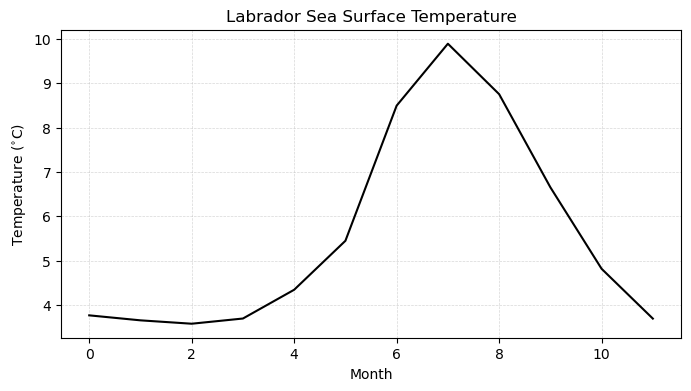

In [20]:
# make a figure
fig = plt.figure(figsize=(8,4))

# plot the temperatures in black
plt.plot(temperature_values, color='black')

# format the axes
plt.ylabel('Temperature ($^{\circ}$C)')
plt.xlabel('Month')
plt.title('Labrador Sea Surface Temperature')
plt.grid(linestyle='--',linewidth=0.5,alpha=0.5)

# show the plot
plt.show()

## Hovmöller Diagrams
In the two exercises above, we investigated properties in the Labrador Sea in two different ways - a comparison in a spatial direction (e.g. vertical) and a comparison through time. A *Hovmöller* diagram allows us to have the best of both worlds, visualizing variations in one spatial direction *and* in time.

Similar to the timeseries plot above, we can loop through all of the available files and store profiles of temperature through time:

In [23]:
# make a list to store the temperature values
# 50 = number of depth cells (len(Z)) and timesteps (12 months
temperature_values = np.zeros((50, 12))

# loop through each file, accessing them by index
for i in range (len(file_list)):

    # identify the file name
    file_name = file_list[i]
    
    # identify path to the data file
    month_file = os.path.join(data_folder,'ECCO','Version4','Release4',
                          'interp_monthly','THETA',file_name)
    
    # read in the data at the surface in the Labrador Sea
    ds = xr.open_dataset(month_file)
    Theta = np.array(ds['THETA'][:])
    ds.close()

    # add the profile to the array
    # more depth, not just surface
    theta = Theta[0, :, lat_index, lon_index]
    temperature_values[:,i] = theta
    

Now, make a plot of the temperature array using either the `pcolormesh` or the `contourf` plotting routines:

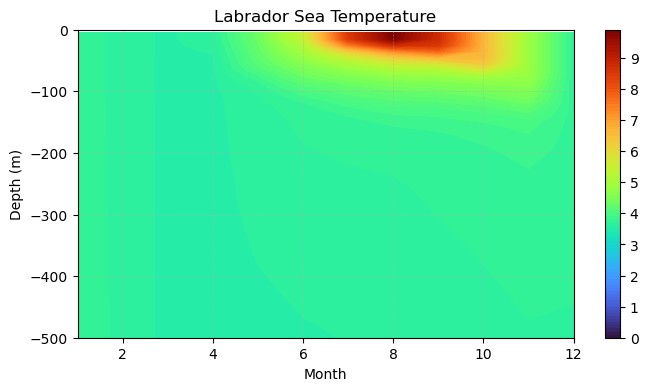

In [27]:
# make a figure
fig = plt.figure(figsize=(8,4))

# plot the temperature array with pcolormesh or contourf
# use 100 levels and a color range of 3.5 to 9
# months (arange makes a range of 1-12, z depth, then values
plt.contourf(np.arange(1,13), Z, temperature_values, 100,cmap='turbo')

# add a colorbar
plt.colorbar()

# format the axes
plt.ylabel('Depth (m)')
plt.xlabel('Month')
plt.title('Labrador Sea Temperature')
plt.grid(linestyle='--',linewidth=0.5,alpha=0.5)
plt.gca().set_ylim([-500,0])

# show the plot
plt.show()